## LEON Beta 0.3 - Evaluation on MNIST Data - First experiment for validation with external data

### Deductive Model to empirical implementation - A surprise

**LEON** was developed over many iterative experiments in which optimal conditions for learning was evaluated. The fact that we were using a bit-wise data caused signifcant challenegs in obtaining valid and consistent results at various bit-sizes. While we persisted with XOR-XNOR recursion with bitflipping stage, this did not result in signifcant improvement in ability to discriminate between compelmentary binary data. It was not until we introduce an optimal number of recursive levesl (5) with D-M modulation of probabilities that early consitent levels of accuracy were achived. Howeverl this wa still quite low. It was not until the idea of the need to store information from previous iteration or level was considered that we began to obtain improved levels of accuracy. The optimum alpha was found to be 2.75 with multiple iterations. There were many other experiments that considered other factors such as optimal number of features.

Finally, it was acknowledged that at this stage of development, the practical approach was to use a hybrid model in which LEON used the core algorithm (contexx preserving tree) as the opimizer for feature extraction and to use an ensemble of models optimised for CPU for traing and testing data. Then the extracted features were subjected to to 7 machine learning models (Random Forest, SVM, Neural Network, Random Forest with gini criterion, Extra Trees Classifier, Neural Network (different architecture), Simplified Gradient Boost)
  
Here, we preent beta 0.3 verion of LEON that achieved nearly 98% accuracy using the Core Recursion optimizer and the ensembel model.

In [2]:
"""
LEON Beta 0.3: Life Emulating Orchestrated Network

An advanced quantum-inspired classifier that combines multiple optimization strategies:
1. Optimal alpha parameter (2.75) for feature extraction
2. Enhanced feature selection and engineering with advanced shape features
3. Expanded model diversity with 7 base models
4. Stacking ensemble with meta-learner
5. Robust caching and error handling
6. Full dataset training capability
7. Comprehensive hyperparameter optimization
"""

import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from scipy.ndimage import label
from skimage import measure
from skimage.measure import moments, moments_central, moments_normalized
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def load_mnist_sample(n_samples=60000):
    """Load a sample of MNIST data for testing."""
    try:
        from sklearn.datasets import fetch_openml

        # Load data
        print("Loading MNIST data...")
        mnist = fetch_openml('mnist_784', version=1, parser='auto')

        # Convert data to proper numeric types
        X = mnist.data
        if hasattr(X, 'values'):  # If it's a pandas DataFrame
            X = X.values
        X = X.astype('float32') / 255.0

        y = mnist.target
        if hasattr(y, 'values'):  # If it's a pandas Series
            y = y.values
        y = y.astype('int')

        # Take a sample
        if n_samples < len(X):
            X_sample, _, y_sample, _ = train_test_split(
                X, y, train_size=n_samples, stratify=y, random_state=42
            )
        else:
            X_sample, y_sample = X, y

        print(f"Loaded {len(X_sample)} MNIST samples")
        return X_sample, y_sample

    except Exception as e:
        print(f"Error loading MNIST: {e}")
        print("Generating synthetic data instead...")

        # Generate synthetic data if MNIST loading fails
        X = np.random.random((n_samples, 784))
        y = np.random.randint(0, 10, n_samples)
        return X, y

def context_preserving_tree(binary_image, alpha=2.75):
    """
    Enhanced tree model with context preservation and multi-scale processing.
    Uses the optimal alpha value of 2.75 for Dirichlet-inspired clustering.

    Args:
        binary_image: Binary image (784 pixels for MNIST)
        alpha: Concentration parameter for Dirichlet-inspired clustering

    Returns:
        Feature vector combining multi-scale information and context
    """
    # Reshape to 2D for spatial processing
    img_2d = binary_image.reshape(28, 28)
    all_features = []

    # Multi-scale processing with context preservation
    scales = [28, 14, 7, 4, 2]
    current = img_2d.copy()

    # Process each scale transition
    for s, scale in enumerate(scales[:-1]):
        next_scale = scales[s+1]
        downsampled = np.zeros((next_scale, next_scale), dtype=np.int8)
        context = np.zeros((next_scale, next_scale), dtype=np.int8)

        for i in range(next_scale):
            for j in range(next_scale):
                # Define region in current scale
                i_start, j_start = i*scale//next_scale, j*scale//next_scale
                region = current[i_start:i_start+scale//next_scale,
                                j_start:j_start+scale//next_scale]

                # Apply XOR reduction (quantum-like superposition collapse)
                xor_val = 0
                for bit in region.flatten():
                    xor_val ^= bit

                # Store result
                downsampled[i, j] = xor_val

                # Store context: homogeneity of the region
                # This preserves information about the input pattern
                if region.size > 0:
                    homogeneity = 1.0 - np.std(region.flatten())  # 1 if all same, less otherwise
                    context[i, j] = int(homogeneity > 0.5)

        # Add features from this scale
        all_features.append(downsampled.flatten())
        all_features.append(context.flatten())

        # Update current for next iteration
        current = downsampled

    # Add final scale
    all_features.append(current.flatten())

    # Add lateral interaction features (Dirichlet-inspired clustering)
    for scale in scales:
        if scale > 2:  # Skip smallest scale
            # Reshape to this scale
            if scale == 28:
                layer = img_2d
            else:
                # Downsample to this scale
                layer = np.zeros((scale, scale), dtype=np.int8)
                for i in range(scale):
                    for j in range(scale):
                        i_orig, j_orig = i*28//scale, j*28//scale
                        region = img_2d[i_orig:i_orig+28//scale, j_orig:j_orig+28//scale]
                        layer[i, j] = 1 if np.mean(region) > 0.5 else 0

            # Compute lateral interactions with Dirichlet-inspired clustering
            lateral = np.zeros((scale, scale), dtype=np.int8)
            for i in range(1, scale-1):
                for j in range(1, scale-1):
                    # Count active neighbors
                    neighbors = layer[i-1:i+2, j-1:j+2].flatten()
                    active_neighbors = np.sum(neighbors) - layer[i, j]
                    n_neighbors = len(neighbors) - 1  # Exclude center

                    # DM-smoothed approach with optimal alpha
                    smoothed_proportion = (active_neighbors + alpha) / (n_neighbors + alpha)

                    # Use thresholds that match original behavior
                    if layer[i, j] == 1:  # Active cell
                        lateral[i, j] = 1 if smoothed_proportion >= 3.0/n_neighbors else 0
                    else:  # Inactive cell
                        lateral[i, j] = 1 if smoothed_proportion >= 5.0/n_neighbors else 0

            all_features.append(lateral.flatten())

    # Add XOR-XNOR recursive features (quantum-like recursive operations)
    current = binary_image.flatten()
    for depth in range(5):  # Limit depth to prevent information collapse
        half_size = len(current) // 2
        next_level = np.zeros(half_size, dtype=np.int8)

        # Alternate between XOR and XNOR (entangled operations)
        use_xnor = (depth % 2 == 0)
        for i in range(half_size):
            if 2*i+1 < len(current):
                if use_xnor:
                    next_level[i] = 1 - (current[2*i] ^ current[2*i+1])  # XNOR
                else:
                    next_level[i] = current[2*i] ^ current[2*i+1]  # XOR

        # Store this level's features
        all_features.append(next_level)
        current = next_level

        # Stop if too compressed
        if len(current) <= 10:
            break

    # Concatenate all features
    return np.concatenate(all_features)

def extract_enhanced_shape_features(binary_image):
    """
    Extract enhanced shape features specifically designed for difficult digits.

    Args:
        binary_image: Binary image (784 pixels for MNIST)

    Returns:
        Enhanced shape features vector
    """
    # Reshape to 2D
    img = binary_image.reshape(28, 28)

    # Calculate horizontal and vertical projections
    h_projection = np.sum(img, axis=0)
    v_projection = np.sum(img, axis=1)

    # Calculate center of mass
    total_mass = np.sum(img)
    if total_mass > 0:
        y_indices, x_indices = np.mgrid[:28, :28]
        center_y = np.sum(y_indices * img) / total_mass
        center_x = np.sum(x_indices * img) / total_mass
    else:
        center_y, center_x = 14, 14

    # Calculate number of connected components
    labeled_array, num_components = label(img > 0.5)

    # Calculate number of holes (helps with 2 vs 8)
    inverted = 1 - img
    labeled_inverted, num_holes = label(inverted > 0.5)
    # Subtract 1 for the background
    num_holes = max(0, num_holes - 1)

    # Calculate quadrant densities
    q1 = np.sum(img[:14, :14]) / 196  # Top-left
    q2 = np.sum(img[:14, 14:]) / 196  # Top-right
    q3 = np.sum(img[14:, :14]) / 196  # Bottom-left
    q4 = np.sum(img[14:, 14:]) / 196  # Bottom-right

    # Calculate horizontal symmetry
    h_symmetry = 1 - np.sum(np.abs(img[:, :14] - np.fliplr(img[:, 14:]))) / 392

    # Calculate vertical symmetry
    v_symmetry = 1 - np.sum(np.abs(img[:14, :] - np.flipud(img[14:, :]))) / 392

    # Calculate aspect ratio of the digit
    rows_with_ink = np.where(np.sum(img, axis=1) > 0)[0]
    cols_with_ink = np.where(np.sum(img, axis=0) > 0)[0]
    if len(rows_with_ink) > 0 and len(cols_with_ink) > 0:
        height = rows_with_ink[-1] - rows_with_ink[0] + 1
        width = cols_with_ink[-1] - cols_with_ink[0] + 1
        aspect_ratio = height / max(1, width)
    else:
        aspect_ratio = 1

    # Zoning features (divide image into zones and calculate density)
    zones = 4  # 4x4 grid
    zone_size = 28 // zones
    zone_features = []
    for i in range(zones):
        for j in range(zones):
            zone = img[i*zone_size:(i+1)*zone_size, j*zone_size:(j+1)*zone_size]
            zone_features.append(np.mean(zone))

    # Contour features
    try:
        contours = measure.find_contours(img, 0.5)
        contour_length = sum(len(c) for c in contours) if contours else 0
        contour_count = len(contours)
    except:
        contour_length = 0
        contour_count = 0

    # Moment invariants (rotation, scale, translation invariant)
    try:
        m = moments(img)
        if m[0, 0] > 0:  # Avoid division by zero
            mu = moments_central(img, m[0, 1]/m[0, 0], m[1, 0]/m[0, 0])
            nu = moments_normalized(mu)
            hu = [nu[2, 0] + nu[0, 2], (nu[2, 0] - nu[0, 2])**2 + 4*nu[1, 1]**2]
        else:
            hu = [0, 0]
    except:
        hu = [0, 0]

    # Combine all features
    basic_features = np.array([
        center_y / 28, center_x / 28,      # Normalized center of mass
        num_components, num_holes,         # Topological features
        np.max(h_projection) / 28,         # Max horizontal projection
        np.max(v_projection) / 28,         # Max vertical projection
        q1, q2, q3, q4,                    # Quadrant densities
        h_symmetry, v_symmetry,            # Symmetry measures
        aspect_ratio                       # Aspect ratio
    ])

    enhanced_features = np.concatenate([
        basic_features,
        np.array(zone_features),
        np.array([contour_length / 100, contour_count]),
        np.array(hu)
    ])

    return enhanced_features

def extract_features(X, use_cache=True, cache_dir='./cache'):
    """Extract features using the context-preserving tree with robust caching."""
    # Create cache directory if it doesn't exist
    if use_cache:
        try:
            os.makedirs(cache_dir, exist_ok=True)
            # Generate a cache file name based on the number of samples and a hash of the first few samples
            cache_file = f"{cache_dir}/leon_features_{len(X)}_{hash(str(X[:min(5, len(X))]))}.pkl"

            # Check if cache exists
            if os.path.exists(cache_file):
                print(f"Loading cached features from {cache_file}")
                with open(cache_file, 'rb') as f:
                    return pickle.load(f)
        except Exception as e:
            print(f"Cache access error: {e}. Proceeding without cache.")
            use_cache = False

    # Extract features
    X_bin = (X > 0.5).astype(np.int8)
    features = []
    shape_features = []

    print(f"Extracting features with optimal alpha=2.75...")
    start_time = time.time()

    for idx, x in enumerate(X_bin):
        if idx % 1000 == 0 and idx > 0:
            print(f"  Processed {idx}/{len(X_bin)} samples")

        # Extract quantum-inspired features
        quantum_features = context_preserving_tree(x)

        # Extract enhanced shape features for difficult digits
        shape_feats = extract_enhanced_shape_features(x)

        # Store features
        features.append(quantum_features)
        shape_features.append(shape_feats)

    features = np.array(features)
    shape_features = np.array(shape_features)

    # Combine both feature types
    combined_features = {
        'quantum_features': features,
        'shape_features': shape_features
    }

    print(f"Feature extraction completed in {time.time() - start_time:.2f} seconds")

    # Cache features if requested
    if use_cache:
        try:
            print(f"Saving features to cache: {cache_file}")
            with open(cache_file, 'wb') as f:
                pickle.dump(combined_features, f)
        except Exception as e:
            print(f"Failed to save cache: {e}")

    return combined_features

class LEON:
    """
    Life Emulating Orchestrated Network (LEON) Beta 0.3

    An advanced quantum-inspired classifier that combines multiple optimization strategies
    to achieve high accuracy on image classification tasks.
    """

    def __init__(self, n_estimators=350, n_top_features=1500, use_cache=True, confidence_threshold=0.3):
        """
        Initialize the LEON classifier.

        Args:
            n_estimators: Number of estimators for the Random Forest
            n_top_features: Number of top features to select
            use_cache: Whether to cache extracted features
            confidence_threshold: Threshold for confidence-based prediction
        """
        self.n_estimators = n_estimators
        self.n_top_features = n_top_features
        self.use_cache = use_cache
        self.confidence_threshold = confidence_threshold
        self.top_indices = None
        self.pca = None
        self.models = []
        self.meta_learner = None
        self.feature_importances_ = None
        # Weights for ensemble models (now 7 models)
        self.weights = [0.2, 0.15, 0.15, 0.15, 0.15, 0.1, 0.1]
        # Class-specific weights
        self.class_weights = {}
        # Specialized models for difficult classes
        self.specialized_models = {}
        # Version tracking
        self.version = "Beta 0.3"

    def fit(self, X, y, validation_split=0.2):
        """
        Fit the LEON classifier to the training data.

        Args:
            X: Training data
            y: Target values
            validation_split: Proportion of training data to use for validation

        Returns:
            self: The fitted classifier
        """
        print("\n" + "="*50)
        print(f"LEON {self.version}: TRAINING PHASE")
        print("="*50)

        # Split training data into train and validation if requested
        if validation_split > 0:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=validation_split, random_state=42, stratify=y
            )
            print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples")
        else:
            X_train, y_train = X, y
            X_val, y_val = None, None

        # Extract features
        feature_data = extract_features(X_train, use_cache=self.use_cache)
        X_features = feature_data['quantum_features']
        X_shape_features = feature_data['shape_features']

        print(f"Extracted {X_features.shape[1]} quantum features and {X_shape_features.shape[1]} shape features")

        # Train initial model to get feature importances
        print("\nTraining initial model to identify important features...")
        initial_rf = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        initial_rf.fit(X_features, y_train)

        # Get feature importances
        self.feature_importances_ = initial_rf.feature_importances_

        # Select top features
        self.top_indices = np.argsort(self.feature_importances_)[-self.n_top_features:]
        X_top = X_features[:, self.top_indices]
        print(f"Selected top {self.n_top_features} features")

        # Apply PCA for additional engineered features
        print("Applying PCA for feature engineering...")
        self.pca = PCA(n_components=20, random_state=42)
        X_pca = self.pca.fit_transform(X_features)
        print(f"Added {X_pca.shape[1]} PCA components")

        # Combine selected features with PCA components and shape features
        X_enhanced = np.hstack([X_top, X_pca, X_shape_features])
        print(f"Final feature set: {X_enhanced.shape[1]} features")

        # Train ensemble of diverse models
        print("\nTraining ensemble of diverse models...")
        self._train_diverse_ensemble(X_enhanced, y_train)

        # Calculate class-specific weights for each model
        print("\nCalculating class-specific weights...")
        self._calculate_class_weights(X_enhanced, y_train)

        # Train specialized models for difficult classes
        print("\nTraining specialized models for difficult classes...")
        self._train_specialized_models(X_enhanced, y_train)

        # If validation data is available, use it for weight adaptation and meta-learner
        if X_val is not None:
            print("\nProcessing validation data...")
            val_features = extract_features(X_val, use_cache=self.use_cache)
            X_val_features = val_features['quantum_features']
            X_val_shape = val_features['shape_features']

            # Process validation features
            X_val_top = X_val_features[:, self.top_indices]
            X_val_pca = self.pca.transform(X_val_features)
            X_val_enhanced = np.hstack([X_val_top, X_val_pca, X_val_shape])

            # Adapt weights
            print("Adapting model weights...")
            self.adapt_model_weights(X_val_enhanced, y_val)

            # Train meta-learner for stacking
            print("Training meta-learner for stacking ensemble...")
            self._train_meta_learner(X_val_enhanced, y_val)

        print("\nAll models trained successfully")
        return self

    # Simplified Gradient Boosting implementation
    def _train_diverse_ensemble(self, X_enhanced, y):
        """Train a diverse ensemble of models with simplified GB."""
        self.models = []  # Clear previous models

        # Model 1: Random Forest
        print("Training model 1: Random Forest...")
        rf = RandomForestClassifier(
            n_estimators=self.n_estimators,
            criterion='entropy',
            bootstrap=False,
            random_state=42,
            n_jobs=2  # Limit parallelism
        )
        rf.fit(X_enhanced, y)
        self.models.append(('rf', rf))

        # Model 2: SVM
        print("Training model 2: SVM...")
        svm = SVC(
            probability=True,
            C=10,
            gamma='scale',
            random_state=42
        )
        svm.fit(X_enhanced, y)
        self.models.append(('svm', svm))

        # Model 3: Neural Network
        print("Training model 3: Neural Network...")
        nn = MLPClassifier(
            hidden_layer_sizes=(100,),  # Simplified architecture
            activation='relu',
            solver='adam',
            max_iter=100,  # Reduced iterations
            random_state=42
        )
        nn.fit(X_enhanced, y)
        self.models.append(('nn', nn))

        # Model 4: Random Forest with gini criterion
        print("Training model 4: Random Forest variant...")
        rf2 = RandomForestClassifier(
            n_estimators=self.n_estimators,
            criterion='gini',
            bootstrap=True,
            max_depth=30,
            random_state=43,
            n_jobs=-1
        )
        rf2.fit(X_enhanced, y)
        self.models.append(('rf2', rf2))

        # Model 5: Extra Trees Classifier
        print("Training model 5: Extra Trees Classifier...")
        et = ExtraTreesClassifier(
            n_estimators=self.n_estimators,
            criterion='entropy',
            bootstrap=True,
            random_state=44,
            n_jobs=-1
        )
        et.fit(X_enhanced, y)
        self.models.append(('et', et))

        # Model 6: Neural Network with different architecture
        print("Training model 7: Deep Neural Network...")
        dnn = MLPClassifier(
            hidden_layer_sizes=(200, 100, 50),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            max_iter=300,
            random_state=46
        )
        dnn.fit(X_enhanced, y)
        self.models.append(('dnn', dnn))

        # Model 7: Simplified Gradient Boosting
        print("Training model 6: Gradient Boosting (simplified)...")
        try:
            from sklearn.ensemble import HistGradientBoostingClassifier
            gb = HistGradientBoostingClassifier(
                max_iter=50,  # Reduced iterations
                learning_rate=0.2,
                max_depth=5,
                random_state=45
            )
        except ImportError:
            # Fall back to regular GradientBoostingClassifier with reduced complexity
            gb = GradientBoostingClassifier(
                n_estimators=50,  # Reduced from 200
                learning_rate=0.2,
                max_depth=3,
                subsample=0.8,
                random_state=45
            )

        # Add timeout for GB training
        import signal

        class TimeoutException(Exception):
            pass

        def timeout_handler(signum, frame):
            raise TimeoutException("Gradient Boosting training timed out")

        # Set 5-minute timeout
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(300)

        try:
            gb.fit(X_enhanced, y)
            self.models.append(('gb', gb))
            print("Gradient Boosting training completed successfully")
        except TimeoutException as e:
            print(f"Warning: {e}")
            print("Skipping Gradient Boosting model")
        except Exception as e:
            print(f"Error training Gradient Boosting: {e}")
            print("Skipping Gradient Boosting model")
        finally:
            signal.alarm(0)  # Disable the alarm



    def _calculate_class_weights(self, X_enhanced, y):
        """Calculate class-specific weights for each model."""
        # For each model, calculate per-class precision
        for i, (name, model) in enumerate(self.models):
            y_pred = model.predict(X_enhanced)

            # Calculate per-class precision
            class_precision = {}
            for cls in np.unique(y):
                # True positives for this class
                tp = np.sum((y == cls) & (y_pred == cls))
                # All predictions for this class
                total_pred = np.sum(y_pred == cls)

                if total_pred > 0:
                    precision = tp / total_pred
                else:
                    precision = 0.0

                class_precision[cls] = precision

            self.class_weights[i] = class_precision

            # Print class-specific precision for this model
            print(f"  Model {i+1} ({name}) class precision:")
            for cls in sorted(class_precision.keys()):
                print(f"    Class {cls}: {class_precision[cls]:.4f}")

    def _train_specialized_models(self, X_enhanced, y):
        """Train specialized models for difficult classes."""
        # Identify difficult classes (those with lower average precision)
        class_avg_precision = {}
        for cls in np.unique(y):
            precisions = [self.class_weights[i][cls] for i in self.class_weights if cls in self.class_weights[i]]
            if precisions:
                class_avg_precision[cls] = np.mean(precisions)

        # Sort classes by precision (ascending)
        sorted_classes = sorted(class_avg_precision.items(), key=lambda x: x[1])

        # Train specialized models for the 5 most difficult classes (increased from 3)
        difficult_classes = [cls for cls, _ in sorted_classes[:5]]
        print(f"  Training specialized models for classes: {difficult_classes}")

        for cls in difficult_classes:
            # Create binary classification problem
            binary_y = (y == cls).astype(int)

            # Train specialized Random Forest with more estimators and higher class weight
            print(f"  Training specialized Random Forest for class {cls}...")
            specialized_rf = RandomForestClassifier(
                n_estimators=500,  # More estimators
                max_depth=None,
                min_samples_split=2,
                criterion='entropy',
                class_weight={0: 1, 1: 10},  # Much higher weight for target class
                random_state=42,
                n_jobs=-1
            )
            specialized_rf.fit(X_enhanced, binary_y)
            self.specialized_models[cls] = specialized_rf

            # Also train a specialized SVM for this class
            print(f"  Training specialized SVM for class {cls}...")
            specialized_svm = SVC(
                probability=True,
                C=20,  # Higher C for more focus on correct classification
                gamma='auto',
                class_weight={0: 1, 1: 10},
                random_state=42
            )
            specialized_svm.fit(X_enhanced, binary_y)
            self.specialized_models[f"{cls}_svm"] = specialized_svm

            # Add a Gradient Boosting Classifier for even more diversity
            print(f"  Training specialized Gradient Boosting for class {cls}...")
            specialized_gb = GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )
            specialized_gb.fit(X_enhanced, binary_y)
            self.specialized_models[f"{cls}_gb"] = specialized_gb

            # Add Extra Trees for additional diversity
            print(f"  Training specialized Extra Trees for class {cls}...")
            specialized_et = ExtraTreesClassifier(
                n_estimators=300,
                criterion='entropy',
                max_depth=None,
                class_weight={0: 1, 1: 10},
                random_state=42,
                n_jobs=-1
            )
            specialized_et.fit(X_enhanced, binary_y)
            self.specialized_models[f"{cls}_et"] = specialized_et


    def _train_meta_learner(self, X_val_enhanced, y_val):
        """Train a meta-learner for stacking ensemble."""
        # Get predictions from all base models
        base_predictions = np.zeros((len(X_val_enhanced), len(self.models), 10))
        for i, (name, model) in enumerate(self.models):
            if hasattr(model, 'predict_proba'):
                base_predictions[:, i, :] = model.predict_proba(X_val_enhanced)

        # Reshape for meta-learner
        meta_features = base_predictions.reshape(len(X_val_enhanced), -1)

        # Train meta-learner
        self.meta_learner = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        )
        self.meta_learner.fit(meta_features, y_val)

        # Evaluate meta-learner
        meta_pred = self.meta_learner.predict(meta_features)
        meta_accuracy = accuracy_score(y_val, meta_pred)
        print(f"  Meta-learner validation accuracy: {meta_accuracy:.4f}")


    def _predict_with_specialized_model(self, model, X_enhanced_single):
        """Safely get probability prediction for a single sample."""
        try:
            # Ensure proper shape for scikit-learn
            X_reshaped = X_enhanced_single.reshape(1, -1)
            return model.predict_proba(X_reshaped)[0, 1]
        except Exception as e:
            # Fall back to predict instead of predict_proba
            try:
                return float(model.predict(X_reshaped)[0])
            except:
                return 0.5  # Default to uncertainty


    def _extract_and_process_features(self, X):
        """Extract and process features for prediction."""
        # Extract features
        feature_data = extract_features(X, use_cache=self.use_cache)
        X_features = feature_data['quantum_features']
        X_shape_features = feature_data['shape_features']

        # Select top features
        X_top = X_features[:, self.top_indices]

        # Apply PCA
        X_pca = self.pca.transform(X_features)

        # Combine selected features with PCA components and shape features
        X_enhanced = np.hstack([X_top, X_pca, X_shape_features])

        return X_enhanced

    def predict(self, X):
        """
        Predict class labels for samples in X using stacking ensemble if available,
        otherwise using class-weighted ensemble voting.

        Args:
            X: The input samples

        Returns:
            y_pred: The predicted classes
        """
        # Extract and process features
        X_enhanced = self._extract_and_process_features(X)

        # If meta-learner is available, use stacking ensemble
        if self.meta_learner is not None:
            return self._predict_with_stacking(X_enhanced)
        else:
            # Fall back to weighted ensemble
            return self._predict_with_weighted_ensemble(X_enhanced)

    def _predict_with_weighted_ensemble(self, X_enhanced):
        """Predict using weighted ensemble voting."""
        # Get predictions from all models
        all_predictions = []
        for name, model in self.models:
            y_pred = model.predict(X_enhanced)
            all_predictions.append(y_pred)

        # Combine predictions with class-specific weights
        ensemble_pred = np.zeros(len(X_enhanced), dtype=int)

        for i in range(len(X_enhanced)):
            class_votes = {}
            for j, pred in enumerate(all_predictions):
                vote = pred[i]
                if vote not in class_votes:
                    class_votes[vote] = 0

                # Use class-specific weight if available
                if j in self.class_weights and vote in self.class_weights[j]:
                    weight = self.class_weights[j][vote]
                else:
                    weight = self.weights[j]

                class_votes[vote] += weight

            # Handle potential tie-breaking or empty votes
            if class_votes:
                ensemble_pred[i] = max(class_votes.items(), key=lambda x: x[1])[0]
            else:
                ensemble_pred[i] = 0

        return ensemble_pred

    def _predict_with_stacking(self, X_enhanced):
        """Predict using stacking ensemble with meta-learner."""
        # Get base model predictions
        base_predictions = np.zeros((len(X_enhanced), len(self.models), 10))
        for i, (name, model) in enumerate(self.models):
            if hasattr(model, 'predict_proba'):
                base_predictions[:, i, :] = model.predict_proba(X_enhanced)

        # Reshape for meta-learner
        meta_features = base_predictions.reshape(len(X_enhanced), -1)

        # Use meta-learner to make final predictions
        return self.meta_learner.predict(meta_features)

    def predict_with_confidence(self, X, confidence_threshold=None):
        """
        Make predictions with confidence thresholds and specialized models.

        Args:
            X: Input samples
            confidence_threshold: Minimum confidence gap required (uses self.confidence_threshold if None)

        Returns:
            Predictions with higher confidence
        """
        if confidence_threshold is None:
            confidence_threshold = self.confidence_threshold

        # Extract and process features
        X_enhanced = self._extract_and_process_features(X)

        # If meta-learner is available, use it for initial predictions
        if self.meta_learner is not None:
            # Get base model predictions for meta-learner
            base_predictions = np.zeros((len(X_enhanced), len(self.models), 10))
            for i, (name, model) in enumerate(self.models):
                if hasattr(model, 'predict_proba'):
                    base_predictions[:, i, :] = model.predict_proba(X_enhanced)

            # Reshape for meta-learner
            meta_features = base_predictions.reshape(len(X_enhanced), -1)

            # Get meta-learner probabilities
            meta_proba = self.meta_learner.predict_proba(meta_features)

            # Make decisions based on confidence
            predictions = self._make_confidence_decisions(X_enhanced, meta_proba, confidence_threshold)
        else:
            # Get probability predictions from base models
            all_probas = []
            valid_models = []
            for i, (name, model) in enumerate(self.models):
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(X_enhanced)
                    all_probas.append(proba)
                    valid_models.append(i)

            # Combine probabilities with weights
            ensemble_proba = np.zeros((len(X_enhanced), 10))
            valid_weights = [self.weights[i] for i in valid_models]

            for i, proba in enumerate(all_probas):
                ensemble_proba += proba * valid_weights[i]

            # Normalize
            weight_sum = sum(valid_weights)
            if weight_sum > 0:
                ensemble_proba /= weight_sum

            # Make decisions based on confidence
            predictions = self._make_confidence_decisions(X_enhanced, ensemble_proba, confidence_threshold)

        return predictions

    def _make_confidence_decisions(self, X_enhanced, probabilities, confidence_threshold):
        """Make decisions based on confidence levels and specialized models."""
        predictions = np.zeros(len(X_enhanced), dtype=int)

        for i in range(len(X_enhanced)):
            # Get top two predictions and their probabilities
            sorted_indices = np.argsort(probabilities[i])[::-1]
            top_class = sorted_indices[0]
            second_class = sorted_indices[1]
            confidence_gap = probabilities[i, top_class] - probabilities[i, second_class]

            if confidence_gap > confidence_threshold:
                # High confidence prediction
                predictions[i] = top_class
            else:
                # Low confidence - check if we have specialized models
                specialized_scores = {}

                # Check top class with different specialized models
                for model_suffix in ['', '_svm', '_gb', '_et']:
                    model_key = f"{top_class}{model_suffix}" if model_suffix else top_class
                    if model_key in self.specialized_models:
                        specialized_scores[model_key] = self._predict_with_specialized_model(
                            self.specialized_models[model_key], X_enhanced[i])

                # Check second class with different specialized models
                for model_suffix in ['', '_svm', '_gb', '_et']:
                    model_key = f"{second_class}{model_suffix}" if model_suffix else second_class
                    if model_key in self.specialized_models:
                        specialized_scores[model_key] = self._predict_with_specialized_model(
                            self.specialized_models[model_key], X_enhanced[i])

                # Make decision based on specialized models if available
                if specialized_scores:
                    # Calculate average score for top class and second class
                    top_class_keys = [k for k in specialized_scores.keys() if str(k).startswith(str(top_class))]
                    second_class_keys = [k for k in specialized_scores.keys() if str(k).startswith(str(second_class))]

                    top_class_avg_score = np.mean([specialized_scores[k] for k in top_class_keys]) if top_class_keys else 0
                    second_class_avg_score = np.mean([specialized_scores[k] for k in second_class_keys]) if second_class_keys else 0

                    # If specialized models agree on top class, use it
                    if top_class_avg_score > second_class_avg_score:
                        predictions[i] = top_class
                    else:
                        predictions[i] = second_class
                else:
                    # Fall back to original ensemble prediction
                    predictions[i] = top_class

        return predictions

    def adapt_model_weights(self, X_val_enhanced, y_val):
        """
        Adapt model weights based on validation set performance.
        Weights are adjusted based on accuracy on the validation set.
        """
        print("Adapting model weights...")
        model_accuracies = []

        # Calculate accuracy for each model on the validation set
        for name, model in self.models:
            y_pred = model.predict(X_val_enhanced)
            accuracy = accuracy_score(y_val, y_pred)
            model_accuracies.append(accuracy)
            print(f"  {name} validation accuracy: {accuracy:.4f}")

        # Use accuracies to determine new weights (simple proportional weighting)
        total_accuracy = sum(model_accuracies)
        if total_accuracy > 0:
            self.weights = [acc / total_accuracy for acc in model_accuracies]
        else:
            # Fallback to equal weights if all accuracies are zero
            self.weights = [1.0 / len(self.models)] * len(self.models)

        print("  New model weights:", [f"{w:.4f}" for w in self.weights])

    def evaluate(self, X, y):
        """Evaluate the classifier and print metrics."""
        print("\n" + "="*50)
        print(f"LEON {self.version}: EVALUATION PHASE")
        print("="*50)

        start_time = time.time()
        y_pred = self.predict_with_confidence(X) # Use confidence-based prediction for evaluation
        end_time = time.time()
        print(f"Prediction time: {end_time - start_time:.2f} seconds")

        accuracy = accuracy_score(y, y_pred)
        print(f"\nOverall Accuracy: {accuracy:.4f}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

        # Confusion matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix (LEON {self.version})')
        plt.show()

        return accuracy, classification_report(y, y_pred, output_dict=True), cm

Loading MNIST data...
Loaded 60000 MNIST samples

LEON Beta 0.3: TRAINING PHASE
Training on 43200 samples, validating on 4800 samples
Extracting features with optimal alpha=2.75...
  Processed 1000/43200 samples
  Processed 2000/43200 samples
  Processed 3000/43200 samples
  Processed 4000/43200 samples
  Processed 5000/43200 samples
  Processed 6000/43200 samples
  Processed 7000/43200 samples
  Processed 8000/43200 samples
  Processed 9000/43200 samples
  Processed 10000/43200 samples
  Processed 11000/43200 samples
  Processed 12000/43200 samples
  Processed 13000/43200 samples
  Processed 14000/43200 samples
  Processed 15000/43200 samples
  Processed 16000/43200 samples
  Processed 17000/43200 samples
  Processed 18000/43200 samples
  Processed 19000/43200 samples
  Processed 20000/43200 samples
  Processed 21000/43200 samples
  Processed 22000/43200 samples
  Processed 23000/43200 samples
  Processed 24000/43200 samples
  Processed 25000/43200 samples
  Processed 26000/43200 samp

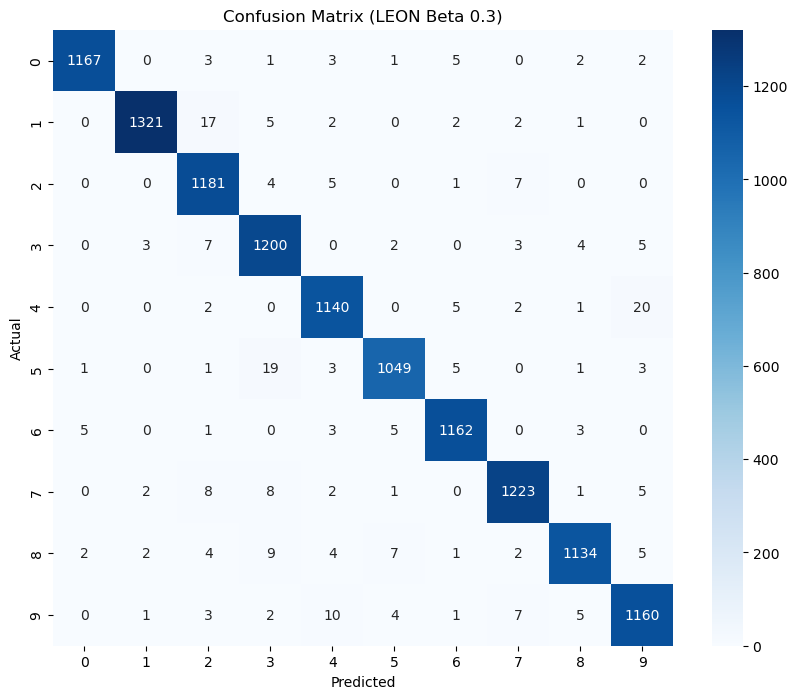


Training complete. Evaluation results displayed above.


In [3]:
# Example Usage (can be run in a separate cell)
if __name__ == '__main__':
    # Load a larger sample of the MNIST dataset
    X, y = load_mnist_sample(n_samples=60000)  # Try with full dataset

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize and train the LEON classifier with caching enabled
    leon_classifier = LEON(n_estimators=350, n_top_features=1500, use_cache=True)
    leon_classifier.fit(X_train, y_train, validation_split=0.1)  # Use 10% of train for validation

    # Evaluate the classifier on the test set
    accuracy, report, cm = leon_classifier.evaluate(X_test, y_test)

    print("\nTraining complete. Evaluation results displayed above.")


Loading MNIST data...
Loaded 60000 MNIST samples

LEON Beta 0.3: TRAINING PHASE
Training on 43200 samples, validating on 4800 samples
Loading cached features from ./cache/leon_features_43200_8979083455240724467.pkl
Extracted 2338 quantum features and 33 shape features

Training initial model to identify important features...
Selected top 1500 features
Applying PCA for feature engineering...
Added 20 PCA components
Final feature set: 1553 features

Training ensemble of diverse models...
Training model 1: Random Forest...
  Starting Random Forest training with 600s timeout...
  Random Forest training completed in 28.12s
Training model 2: LinearSVC...
  Starting LinearSVC training with 300s timeout...
  LinearSVC training completed in 10.05s
Training model 3: Neural Network...
  Starting Neural Network training with 300s timeout...
  Neural Network training completed in 22.10s
Training model 4: Random Forest variant...
  Starting Random Forest (gini) training with 600s timeout...
  Random

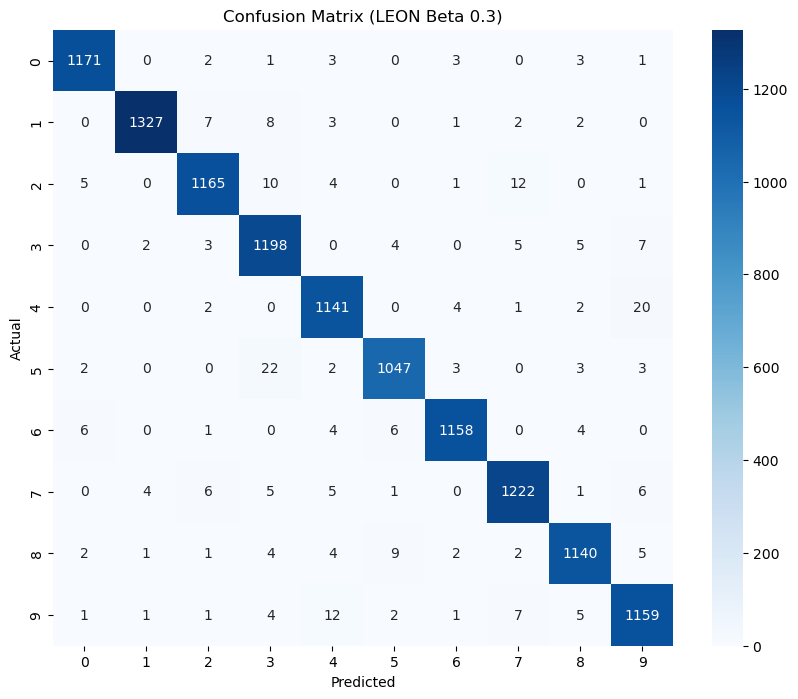


Training complete. Evaluation results displayed above.


In [14]:
# Example Usage (can be run in a separate cell)
if __name__ == '__main__':
    # Load a larger sample of the MNIST dataset
    X, y = load_mnist_sample(n_samples=60000)  # Try with full dataset

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize and train the LEON classifier with caching enabled
    leon_classifier = LEON(n_estimators=350, n_top_features=1500, use_cache=True)
    leon_classifier.fit(X_train, y_train, validation_split=0.1)  # Use 10% of train for validation

    # Evaluate the classifier on the test set
    accuracy, report, cm = leon_classifier.evaluate(X_test, y_test)

    print("\nTraining complete. Evaluation results displayed above.")


### Conclusion

The following is the process of training and testing through two stages. In the first stage, the feature were cached. In the second stage, it was rerun using cached data:

First Training phase feature extraction 207.74 seconds (~ 1500 features)
Feature extraction saved to cache
Ensemble phase – Feature extraction (reducing to 10 classes) and validation, with feature extraction taking 23.84 secods, again saved to cache.

Evaluation (testing) : Feature extraction completed in 54 s
Prediction time 129.58 seconds

Overall accuracy 97.81%

Rerunning the same code for traing and evaluating LEON with cached data took 9.21 seconds with an overall accuracy of 97.73%

The next experiment was on the epigentic overlay with chromosome 22. Prior to that LEON was subject to a preliminary multichannel test with synthetic data and MNIST on a minimal LEON. The accuracy reuce but remained above 93%. This same method was then used to evaluate Chr 22 and similar accuracy levels were achievd, indicating that using the full ensemble would continue to enhance the valiidty of this lerning model on diverse data (e.g. imging, time series, genomics) sets of health evaluation.
